In [1]:
import os,importlib,numpy,json
import math
import random
import statistics
import seaborn as sns
import json 
from sklearn import linear_model


import scipy,scipy.stats

#import miner_20190520 as miner

import pandas
pandas.options.display.max_rows=100
pandas.set_option('display.max_colwidth',-1)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.pyplot.rcParams['axes.axisbelow']=True
matplotlib.rcParams.update({'font.size':18,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':30})
matplotlib.rcParams['pdf.fonttype']=42

In [2]:
# organize programs + states into a list. ith element are the regulons in the (i+1)th programs
with open("transcriptional_programs.json") as TP:
    prog = json.load(TP)
programs=[]
for i in range(1,141):
    I=str(i)
    programs.append(prog[I])
    
with open("transcriptional_states.json") as TS:
    stat = json.load(TS)
states=[]
for i in range(1,len(stat)):
    I=str(i)
    states.append(stat[I])
    
expData = pandas.read_csv('MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_TPM.txt', sep="\s+", header=0, index_col=0)
regulonDf=pandas.read_csv("regulonDf.csv", header=0, index_col=0)
patients=list(expData.columns)

In [3]:
#get genes that belong to regulon
regs_List=[list(regulonDf.loc[regulonDf['Regulon_ID']==x,'Gene']) for x in list(set(regulonDf.loc[:,"Regulon_ID"]))]

In [5]:
#genes in a given program
progGenes=[]
for x in programs:
    progInt=[]
    for y in x:
        for z in range(len(regs_List[int(y)-1])):
            progInt.append(regs_List[int(y)-1][z])
    progGenes.append(progInt)  
#i now realize I do not need to get the programs and instead just need to 
#averafe gene expression across the patients in a state. This is easier

In [4]:
#get genes in columns. ignore the ERC ones (for now?)
cols=expData.columns.values.tolist()
statesUnAv=[]
for x in range(len(states)):
    statesUnAvInt=[list(expData.loc['ENSG00000238602':,states[x][y]]) for y in range(len(states[x])) if states[x][y] in cols]
    statesUnAv.append(statesUnAvInt)

In [5]:
#normalize each patient by it's max before taking the average
statesUnAvNorm=[]
for x in range(len(statesUnAv)):
    statesNormInt=[]
    for y in range(len(statesUnAv[x])):
        statArray=numpy.asarray(statesUnAv[x][y])#/(max(numpy.asarray(statesUnAv[x][y])))
        statesNormInt.append(list(statArray))
    statesUnAvNorm.append(statesNormInt)   

In [6]:
#compute average gene expression. put statesUnAv[i] in an array, transpose and compute average of each row for each i.
stateAv=[]
stateAv2=[]
stateSD=[]
stateSD2=[]
for x in range(len(statesUnAvNorm)):
    statesArray=numpy.asarray(statesUnAvNorm[x]).transpose()
    stateAvInt=[[x,numpy.average(statesArray[x])] for x in range(len(statesArray))]
    stateAvInt2=[numpy.average(statesArray[x]) for x in range(len(statesArray))]
    stateSDInt=[[x,numpy.std(statesArray[x])] for x in range(len(statesArray))]
    stateSDInt2=[numpy.std(statesArray[x]) for x in range(len(statesArray))]
    stateSD.append(stateSDInt)
    stateSD2.append(stateSDInt2)
    stateAv.append(stateAvInt)
    stateAv2.append(stateAvInt2)
def sortSecond(val): 
    return val[1]

#then sort them!
for x in range(len(stateAv)):
    stateAv[x].sort(key=sortSecond,reverse=True)
       


In [7]:
stateOrd=[]
stateAvOrd=[]
for x in range(len(stateAv)):
    stateArrayOrd=numpy.asarray(stateAv[x]).transpose()
    stateOrd.append(list(stateArrayOrd[0]))
    stateAvOrd.append(list(stateArrayOrd[1]))
    
#stateOrd contains the gene ranks ordered by TPM 
#and labeled by their row in the expData frame starting with the ENGS genes
#difficulty is dealing with degenerate TPMs. zero expresisons will get mapped to itself.


In [8]:
stateStd=[]
stateStdOrd=[]
for x in range(len(stateAv)):
    stateStd.append([stateSD[x][int(y)] for y in stateOrd[x]])
    
for x in range(len(stateStd)):
    stateStdOrd.append([stateStd[x][y][1] for y in range(len(stateStd[x]))])

In [9]:
#find the state with the min # of expressed genes
nonZero=[]
for y in range(len(stateAv)):
    nonZero.append([stateAv[y][x] for x in range(len(stateAv[0])) if stateAv[y][x][1]!=0])
for x in range(len(nonZero)):
    print(len(nonZero[x]))

 

44203
39022
44808
40710
38934
34398
43373
39801
38213
37495
42617
39015
37979
40207
42612
43357
40323
37951
32514
43434
38159
36064
41428
32215


In [10]:
#take only the non-zero expressed genes
stateOrd2=[]
for x in range(len(stateOrd)):
    stateOrd2.append(stateOrd[x][:32215])
#find the genes which are common to all

In [13]:
statesInt=list(set(stateOrd2[0])&set(stateOrd2[1]))
print(len(statesInt))
for x in range(22):
    statesInt=list(set(statesInt)&set(stateOrd2[x+2]))
    print(len(statesInt))


30179
29499
28909
28402
27340
26889
26642
26071
25858
25727
25528
25407
25264
25231
25210
25142
25089
24752
24731
24651
24519
24478
24035


In [14]:
comGeneOrd=[]
for x in range(len(stateOrd2)):
    comGeneOrd.append([y for y in stateOrd2[x] if y in statesInt]) 

In [ ]:
patientOrd=comGeneOrd[0]

sprRank=[]
intercepts=[]

for y in range(len(comGeneOrd)): 
    posInt=[]
    posFin=[]
    for x in patientOrd:
        posInt.append([patientOrd.index(x)])
        posFin.append(comGeneOrd[y].index(x))
    
    reg=linear_model.LinearRegression()
    reg.fit(numpy.asarray(posInt),numpy.asarray(posFin))
    sprRank.append(reg.coef_)
    intercepts.append(reg.intercept_)    

In [106]:
#find smallest X such that the first X genes are common to all 24 states
targ=25
redStatesInt=[]
while targ != len(redStatesInt):
    if targ == len(redStatesInt):
        break
    if off == 24035:
        break
    redGeneOrd=[]
    for x in range(len(comGeneOrd)):
        redGeneOrd.append(comGeneOrd[x][:targ])
    redStatesInt=list(set(redGeneOrd[0])&set(redGeneOrd[1]))
    for x in range(22):
        redStatesInt=list(set(redStatesInt)&set(redGeneOrd[x+2]))
    targ=targ+1
    print([len(redStatesInt),targ])

[4, 26]
[4, 27]
[4, 28]
[4, 29]
[5, 30]
[5, 31]
[5, 32]
[6, 33]
[6, 34]
[6, 35]
[6, 36]
[6, 37]
[6, 38]
[7, 39]
[8, 40]
[8, 41]
[8, 42]
[9, 43]
[9, 44]
[9, 45]
[11, 46]
[11, 47]
[11, 48]
[12, 49]
[12, 50]
[13, 51]
[13, 52]
[14, 53]
[14, 54]
[14, 55]
[15, 56]
[16, 57]
[16, 58]
[16, 59]
[16, 60]
[16, 61]
[16, 62]
[16, 63]
[16, 64]
[16, 65]
[16, 66]
[17, 67]
[18, 68]
[19, 69]
[20, 70]
[21, 71]
[23, 72]
[24, 73]
[25, 74]
[27, 75]
[27, 76]
[29, 77]
[29, 78]
[29, 79]
[29, 80]
[29, 81]
[30, 82]
[30, 83]
[30, 84]
[30, 85]
[30, 86]
[30, 87]
[30, 88]
[30, 89]
[30, 90]
[30, 91]
[30, 92]
[30, 93]
[30, 94]
[31, 95]
[32, 96]
[32, 97]
[32, 98]
[34, 99]
[34, 100]
[36, 101]
[36, 102]
[36, 103]
[37, 104]
[40, 105]
[42, 106]
[43, 107]
[45, 108]
[45, 109]
[46, 110]
[47, 111]
[47, 112]
[47, 113]
[49, 114]
[49, 115]
[50, 116]
[50, 117]
[52, 118]
[53, 119]
[54, 120]
[54, 121]
[56, 122]
[57, 123]
[58, 124]
[60, 125]
[62, 126]
[62, 127]
[64, 128]
[65, 129]
[66, 130]
[67, 131]
[68, 132]
[69, 133]
[69, 134]
[70,

[481, 880]
[481, 881]
[482, 882]
[482, 883]
[482, 884]
[483, 885]
[483, 886]
[483, 887]
[484, 888]
[485, 889]
[485, 890]
[486, 891]
[486, 892]
[486, 893]
[488, 894]
[489, 895]
[489, 896]
[490, 897]
[493, 898]
[494, 899]
[494, 900]
[494, 901]
[495, 902]
[495, 903]
[496, 904]
[496, 905]
[496, 906]
[497, 907]
[497, 908]
[497, 909]
[499, 910]
[499, 911]
[499, 912]
[500, 913]
[501, 914]
[501, 915]
[501, 916]
[501, 917]
[501, 918]
[501, 919]
[501, 920]
[501, 921]
[501, 922]
[501, 923]
[501, 924]
[501, 925]
[501, 926]
[501, 927]
[501, 928]
[502, 929]
[503, 930]
[506, 931]
[507, 932]
[507, 933]
[507, 934]
[507, 935]
[507, 936]
[507, 937]
[507, 938]
[507, 939]
[507, 940]
[508, 941]
[508, 942]
[509, 943]
[509, 944]
[509, 945]
[509, 946]
[510, 947]
[511, 948]
[511, 949]
[511, 950]
[511, 951]
[512, 952]
[512, 953]
[512, 954]
[513, 955]
[513, 956]
[513, 957]
[514, 958]
[514, 959]
[515, 960]
[515, 961]
[515, 962]
[515, 963]
[516, 964]
[517, 965]
[517, 966]
[517, 967]
[517, 968]
[518, 969]
[518, 970]

KeyboardInterrupt: 

In [133]:
#do a similar thing but fix the number of genes you want to analyze 
#and see if there is a sequence of that many genes at some point in the list
def sortThird(val): 
    return val[2]
targ=100
dataComp=[]
while targ<1000:
    off=0
    dataFull=[]
    redStatesInt=[]
    while targ != len(redStatesInt):  
        redGeneOrd=[]
        for x in range(len(comGeneOrd)):
            redGeneOrd.append(comGeneOrd[x][off:(targ+off)])
        redStatesInt=list(set(redGeneOrd[0])&set(redGeneOrd[1]))
        for x in range(22):
            redStatesInt=list(set(redStatesInt)&set(redGeneOrd[x+2]))
        
        if targ == len(redStatesInt):
            break
        if (targ+off) == 24035:
            break
        data=[off,targ+off,len(redStatesInt)]
        if data[2]!=0:
            dataFull.append(data)
        off=off+1
    dataFull.sort(key=sortThird,reverse=True)
    dataComp.append([dataFull[0],dataFull[0][2]/targ])
    targ=targ+10

KeyboardInterrupt: 

In [138]:
def sortSecond(val): 
    return val[1]
dataComp.sort(key=sortSecond,reverse=True)
dataComp

[[[0, 240, 143], 0.5958333333333333],
 [[0, 250, 148], 0.592],
 [[0, 230, 135], 0.5869565217391305],
 [[0, 270, 158], 0.5851851851851851],
 [[0, 260, 152], 0.5846153846153846],
 [[0, 290, 168], 0.5793103448275863],
 [[0, 300, 173], 0.5766666666666667],
 [[0, 210, 121], 0.5761904761904761],
 [[0, 200, 115], 0.575],
 [[0, 280, 161], 0.575],
 [[0, 190, 109], 0.5736842105263158],
 [[13, 233, 126], 0.5727272727272728],
 [[0, 530, 303], 0.5716981132075472],
 [[0, 310, 177], 0.5709677419354838],
 [[0, 540, 308], 0.5703703703703704],
 [[0, 320, 182], 0.56875],
 [[0, 180, 102], 0.5666666666666667],
 [[0, 520, 294], 0.5653846153846154],
 [[0, 560, 315], 0.5625],
 [[0, 550, 309], 0.5618181818181818],
 [[0, 330, 185], 0.5606060606060606],
 [[0, 340, 190], 0.5588235294117647],
 [[0, 580, 323], 0.5568965517241379],
 [[0, 510, 284], 0.5568627450980392],
 [[0, 650, 361], 0.5553846153846154],
 [[0, 710, 394], 0.5549295774647888],
 [[0, 660, 366], 0.5545454545454546],
 [[0, 570, 316], 0.5543859649122806

148

In [15]:
#take the top targ or each state and take their common genes and run analysis on that

redGeneOrd=[]
off=0
targ=250
for x in range(len(comGeneOrd)):
    redGeneOrd.append(comGeneOrd[x][off:(targ+off)])
redStatesInt=list(set(redGeneOrd[0])&set(redGeneOrd[1]))
for x in range(22):
    redStatesInt=list(set(redStatesInt)&set(redGeneOrd[x+2]))
geneRedFin=[]
for x in range(len(comGeneOrd)):
    geneRedFin.append([x for x in comGeneOrd[x] if x in redStatesInt])

In [18]:
#randomly choose a patient
r=random.randrange(0,23)
print(r+1)
pat=states[r][random.randrange(0,len(states[r]))]
patPre=list(expData.loc['ENSG00000238602':,pat])
patPreNorm=list(numpy.asarray(patPre)/max(numpy.asarray(patPre)))

    

preSort=[[int(x),patPreNorm[int(x)]] for x in redStatesInt]
preSort.sort(key=sortSecond,reverse=True)
patientOrd=[preSort[x][0] for x in range(len(preSort))]
patientOrdAv=[preSort[x][1] for x in range(len(preSort))]


sprRank=[]
intercepts=[]

for y in range(len(geneRedFin)): 
    posInt=[]
    posFin=[]
    for x in patientOrd:
        posInt.append([patientOrd.index(x)])
        posFin.append(geneRedFin[y].index(x))
    
    reg=linear_model.LinearRegression()
    reg.fit(numpy.asarray(posInt),numpy.asarray(posFin))
    sprRank.append(reg.coef_)
    intercepts.append(reg.intercept_) 
    
print(sprRank.index(max(sprRank))+1)

stateSDRed=[stateSD2[r][x] for x in patientOrd]
stateAvRed=[stateAv2[r][x] for x in patientOrd]
z_score=[]
for x in range(len(patientOrdAv)):
    z_score.append(abs(patientOrdAv[x]-stateAvRed[x])/(stateSDRed[x]))
print([max(z_score),z_score.index(max(z_score))])

error=abs(sprRank[r]-max(sprRank))
print(error)

21
21
[5.6591017026511246, 146]
[0.]


In [24]:
#do a cycle decomposition on the permutations
cycFin=[]
for y in range(len(geneRedFin)):
    cycles=[]
    cyclesTally=[]
    for x in patientOrd:
        p=patientOrd.index(x)
        if p in cyclesTally:
            continue
        else: 
            cycInt=[]
            cycInt.append(p)
            cyclesTally.append(p)
            z=geneRedFin[y].index(x)
            if z==p:
                cycles.append(cycInt)   
            else:    
                for w in range(1000):
                    cycInt.append(z)
                    cyclesTally.append(z)
                    q=patientOrd[z]
                    z=geneRedFin[y].index(q)
                    if z==p: 
                        break
                cycles.append(cycInt)
    cycFin.append(cycles)  
cycLen=[len(cycFin[x]) for x in range(len(cycFin))]

In [194]:
stateSDRed=[stateSD2[r][x] for x in patientOrd[0]]
stateAvRed=[stateAv2[r][x] for x in patientOrd[0]]

TypeError: 'int' object is not iterable

In [20]:
#take the top targ or each state and take their common genes and run analysis on that

redGeneOrd=[]
off=0
targ=250
for x in range(len(comGeneOrd)):
    redGeneOrd.append(comGeneOrd[x][off:(targ+off)])
redStatesInt=list(set(redGeneOrd[0])&set(redGeneOrd[1]))
for x in range(22):
    redStatesInt=list(set(redStatesInt)&set(redGeneOrd[x+2]))
geneRedFin=[]
for x in range(len(comGeneOrd)):
    geneRedFin.append([x for x in comGeneOrd[x] if x in redStatesInt])

Patients predicted with 46.81564245810056 percent accuracy.


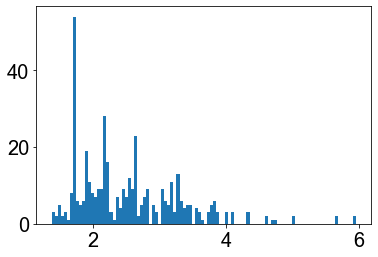

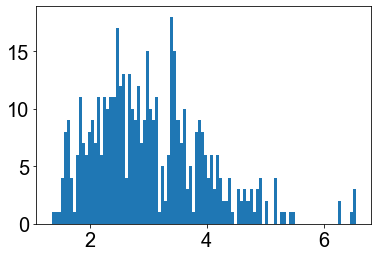

In [21]:
#lets do this a lot! 
z_pos=[]
z_false=[]
error=[]

for z in range(1000):
    r=random.randrange(0,23)
    #print(r+1)
    pat=states[r][random.randrange(0,len(states[r]))]
    if pat not in patients: 
        continue

    patPre=list(expData.loc['ENSG00000238602':,pat])
    patPreNorm=list(numpy.asarray(patPre))#/max(numpy.asarray(patPre)))

    

    preSort=[[int(x),patPreNorm[int(x)]] for x in redStatesInt]
    preSort.sort(key=sortSecond,reverse=True)
    patientOrd=[preSort[x][0] for x in range(len(preSort))]
    patientOrdAv=[preSort[x][1] for x in range(len(preSort))]


    sprRank=[]
    intercepts=[]

    for y in range(len(geneRedFin)): 
        posInt=[]
        posFin=[]
        for x in patientOrd:
            posInt.append([patientOrd.index(x)])
            posFin.append(geneRedFin[y].index(x))
    
        reg=linear_model.LinearRegression()
        reg.fit(numpy.asarray(posInt),numpy.asarray(posFin))
        sprRank.append(reg.coef_)
        intercepts.append(reg.intercept_) 
    
    #print(sprRank.index(max(sprRank))+1)

    stateSDRed=[stateSD2[r][x] for x in patientOrd]
    stateAvRed=[stateAv2[r][x] for x in patientOrd]
    z_score=[]
    for x in range(len(patientOrdAv)):
        z_score.append(abs(patientOrdAv[x]-stateAvRed[x])/(stateSDRed[x]))
    if sprRank.index(max(sprRank))+1 == r+1:
        z_pos.append(max(z_score))
    else: 
        z_false.append(max(z_score))
        error.append(abs(sprRank[r]-max(sprRank)))
print('Patients predicted with {} percent accuracy.'.format(len(z_pos)/(len(z_pos)+len(z_false))*100))
plt.hist(z_pos,100)
plt.show()
plt.hist(z_false,100)
plt.show()

In [366]:
len(patientOrdAv)

148

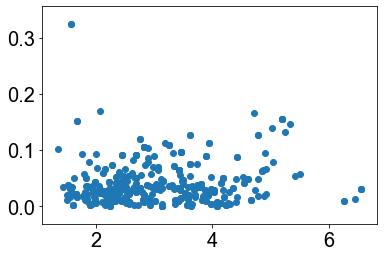

In [22]:
plt.scatter(z_false,error)

In [341]:
len(set(z_false))/len(z_false)

0.5494505494505495

In [356]:
len(set(z_false))

250

In [353]:
total=numpy.asarray([len(states[x]) for x in range(len(states))])
sum(total)

734

In [360]:
len(set(z_pos))

149

In [23]:
expData

,MMRF_2490_1_BM,MMRF_2499_1_BM,MMRF_1089_1_BM,MMRF_1778_1_BM,MMRF_1777_1_BM,MMRF_1153_1_BM,MMRF_1392_1_BM,MMRF_1325_1_BM,MMRF_1846_1_BM,MMRF_1935_1_BM,...,MMRF_1847_1_BM,MMRF_1787_1_BM,MMRF_1048_1_BM,MMRF_2437_1_BM,MMRF_1242_5_BM,MMRF_1497_1_BM,MMRF_1380_2_BM,MMRF_1700_1_BM,MMRF_1918_1_BM,MMRF_1670_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ERCC-00170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERCC-00145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
cycFin[1]

[[0],
 [1],
 [2,
  6,
  9,
  12,
  11,
  20,
  21,
  32,
  118,
  101,
  92,
  46,
  76,
  77,
  55,
  37,
  38,
  54,
  98,
  67,
  80,
  28,
  22,
  19,
  15,
  29,
  36,
  130,
  140,
  119,
  104,
  49,
  39,
  66,
  35,
  25,
  34,
  62,
  69,
  86,
  75,
  81,
  84,
  64,
  79,
  125,
  121,
  126,
  120,
  132,
  137,
  142,
  123,
  94,
  97,
  87,
  73,
  145,
  131,
  138,
  124,
  95,
  61,
  78,
  74,
  85,
  93,
  108,
  89,
  72,
  100,
  136,
  129,
  117,
  141,
  96,
  113,
  109,
  102,
  128,
  115,
  114,
  110,
  82,
  106,
  105,
  71,
  146],
 [3,
  7,
  5,
  8,
  18,
  43,
  50,
  30,
  23,
  52,
  51,
  60,
  41,
  57,
  53,
  99,
  58,
  122,
  144,
  147,
  17,
  116,
  127,
  134,
  139,
  143,
  4],
 [10, 16, 14],
 [13],
 [24, 63, 45, 33, 70, 42, 26, 27, 44, 103, 83, 107, 59, 68, 48, 31],
 [40, 135, 111, 91, 56, 65, 47],
 [88, 90],
 [112],
 [133]]